# Fault Detection with VAR Models

### Plot the dataset

In [9]:
# Importing packages and libraries
from pandas import read_csv
import pandas as pd
import numpy as np
import pickle
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [10]:
def plot_multiple_series(actual, pred, attr):
    
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(actual.iloc[:,i], label="actual")
        plt.plot(pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()
#     return



In [11]:
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)



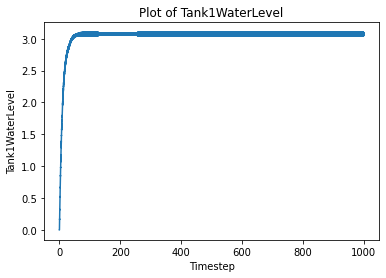

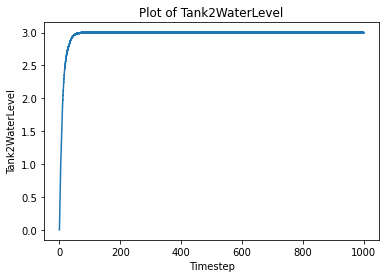

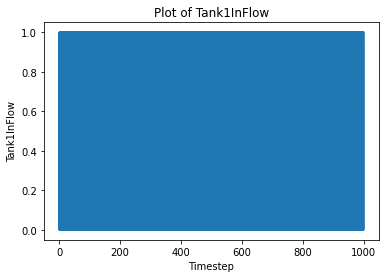

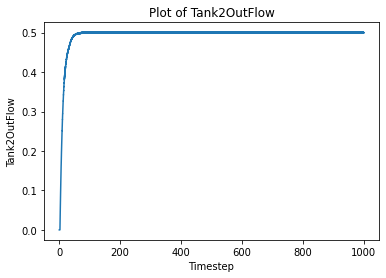

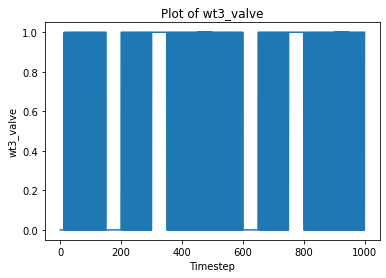

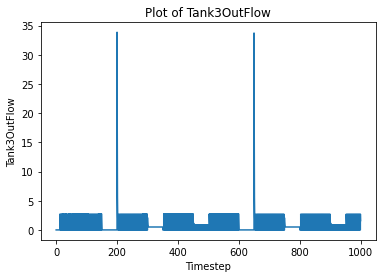

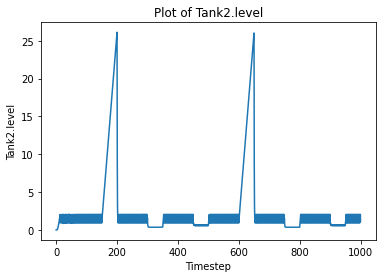

In [12]:
def plot_series(series, attr):
    for i in range(len(attr)):
        title = "Plot of "+str(attr[i])
        actual = series.iloc[:,i]
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel(attr[i])
        plt.plot(actual)
        plt.show()
        
file = 'test_series.csv'
df_raw = read_csv(file, header=0, index_col=0)
attr = list(pd.read_csv(file).columns.values)[1:]        
series = df_raw.iloc[:40000,:]
plot_series(series, attr)

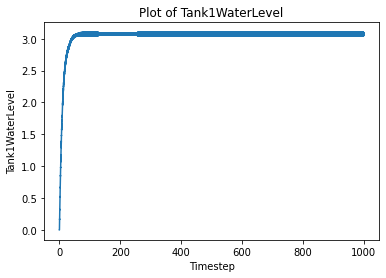

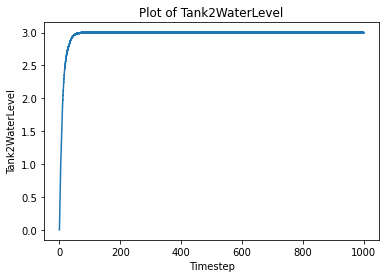

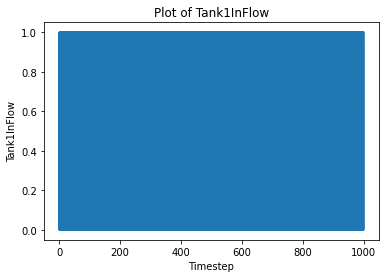

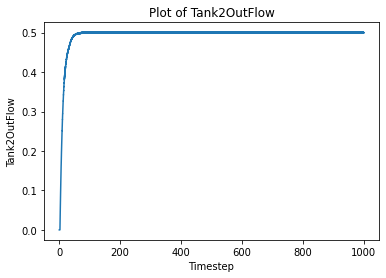

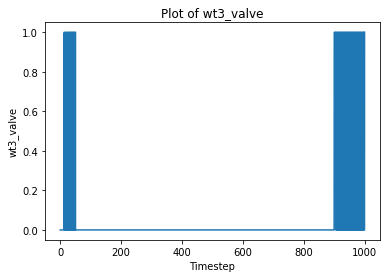

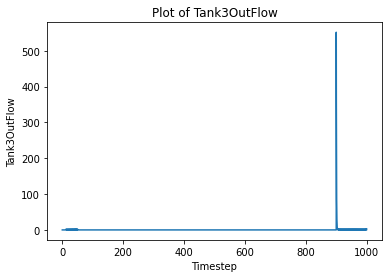

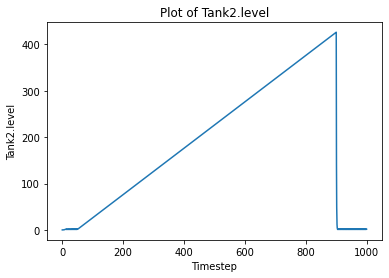

In [13]:
file2 = 'stuckat0_training.csv'
df_train = read_csv(file2, header=0, index_col=0)
attr = list(pd.read_csv(file2).columns.values)[1:]        
series2 = df_train.iloc[:40000,:]
plot_series(series2, attr)

### Normalisation of the golden dataset
##### This is to obtain the mean and standard deviation that would be used for normalising all the datasets

In [14]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)



def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)



normalised_data = normalise_timeseries(df_raw)

In [15]:
testData = normalised_data
testData

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.699801,-0.399607,-0.564448
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.699801,-0.399607,-0.564448
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.699801,-0.399607,-0.564448
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.699801,-0.399607,-0.564448
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.699801,-0.399607,-0.564448
...,...,...,...,...,...,...,...
999.80,0.165423,0.123577,0.998751,0.126510,1.428978,1.245761,-0.249446
999.85,0.239056,0.140814,0.998751,0.133595,1.428978,1.179017,-0.262224
999.90,0.175745,0.174565,-1.001251,0.169767,1.428978,1.085672,-0.280094


In [16]:
# Train Test Split
nobs = 3000
# train = df[:-nobs]
train = testData.iloc[:-nobs]
test = testData.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### Load the saved models

In [17]:
# The saved models are loaded to reconstruct the VAR
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
with open('var_golden_model.pkl', 'rb') as f:
    golden_model = pickle.load(f)

with open('var_ctrl_valueFlip_perm.pkl', 'rb') as vf:
    valueFlip_model = pickle.load(vf)    

with open('var_ctrl_stuckat0_perm.pkl', 'rb') as stuck0:
    stuckat0_model = pickle.load(stuck0)    

with open('var_ctrl_stuckat1_perm.pkl', 'rb') as stuck1:
    stuckat1_model = pickle.load(stuck1)



In [18]:

# golden_model = VAR.load('var_golden_model.pkl')

# Retrieve the lag order
lag_order = golden_model.k_ar
# lag_order = 19

# Prepare new data
# newData = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
# newData = newData[attr]
# newData = newData[-lag_order:]
# newData = newData[:200,:]

# Initialise the VAR model
model_input = train.values
# model_input = newData.values
# golden_model.initialize_known(model_input)

# Make predictions
predictions = golden_model.forecast(model_input, steps=5)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=train.columns)

print(predictions_df)


   Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
0         0.171089         0.124012     1.044288      0.126649   1.128839   
1         0.277439         0.156179     1.022784      0.145222   0.771641   
2         0.176344         0.176959    -1.030201      0.172088   0.586524   
3         0.055115         0.158527    -1.015954      0.170605   0.484350   
4         0.073819         0.130663     1.094183      0.144792   0.380408   

   Tank3OutFlow  Tank2.level  
0      1.269853    -0.360450  
1      0.863329    -0.344346  
2      0.422194    -0.432808  
3      0.262671    -0.376209  
4      0.176259    -0.402183  


In [19]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
850.05,0.165423,0.123577,0.998751,0.126510,1.428978,1.783620,-0.146474
850.10,0.270704,0.154650,0.998751,0.144185,1.428978,1.641499,-0.173682
850.15,0.175745,0.174565,-1.001251,0.169767,1.428978,1.553208,-0.190586
850.20,0.057638,0.156503,-1.001251,0.168293,1.428978,1.429786,-0.214214
850.25,0.068970,0.129598,0.998751,0.143823,1.428978,1.353086,-0.228899
...,...,...,...,...,...,...,...
999.80,0.165423,0.123577,0.998751,0.126510,1.428978,1.245761,-0.249446
999.85,0.239056,0.140814,0.998751,0.133595,1.428978,1.179017,-0.262224
999.90,0.175745,0.174565,-1.001251,0.169767,1.428978,1.085672,-0.280094


### Plot the input signals

In [20]:
def plot_multiple_series(actual, pred, attr):
    if len(actual) != len(pred):
        return "Error: The lengths of the two data must be the same!"
    x = range(len(pred))
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(x, actual.iloc[:,i], label="actual")
        plt.plot(x, pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()
#     return


In [21]:
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)

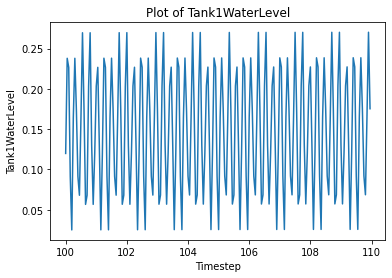

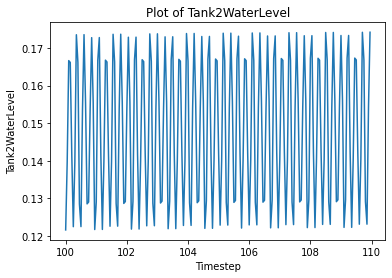

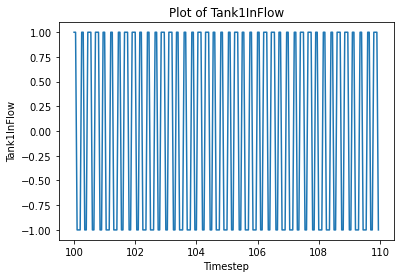

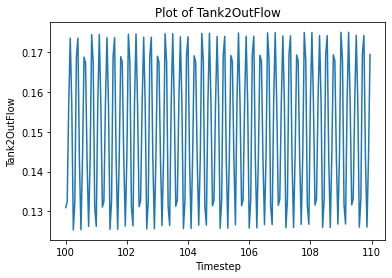

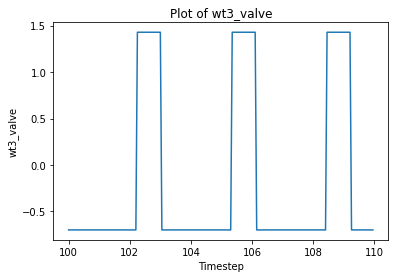

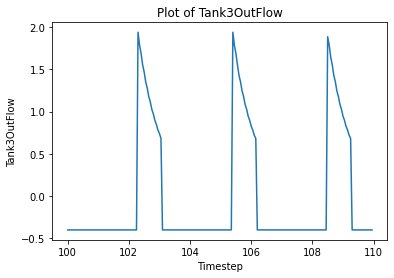

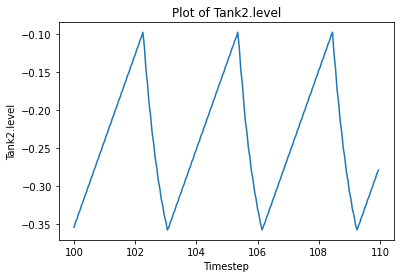

In [22]:
## SPecify the signal range
begin = 2000
finish = 2200
input1 = testData.iloc[begin:finish,:]

## Visualise the input signals
plot_series(input1,attr)

# attr = list(pd.read_csv('test_series.csv').columns.values)[1:]
# for i in range(len(attr)):
#     title = "Input of {}".format(attr[i])
#     plt.title(title)
#     plt.xlabel("Timesteps")
#     plt.ylabel("Normalised values")
#     plt.plot(input1.iloc[:,i])
#     plt.show()

### Predict with the pretrained models
#### Golden model

In [23]:
steps = 15
predictions = golden_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=input1.columns)

print(predictions_df)

    Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
0          0.058765         0.156024    -1.089751      0.167446  -0.670787   
1          0.071787         0.129422     0.932493      0.143208  -1.252766   
2          0.203359         0.130148     0.925554      0.127167  -1.382074   
3          0.268779         0.155136     0.902606      0.144505  -1.414248   
4          0.133032         0.174068    -1.040289      0.175280  -1.345082   
5          0.060948         0.157256    -1.021014      0.168446  -1.285463   
6          0.122333         0.124300     0.959060      0.133180  -1.139915   
7          0.205096         0.132444     0.928664      0.129335  -0.956566   
8          0.230721         0.169890    -1.065634      0.159712  -0.740067   
9          0.134980         0.175966    -1.043168      0.177060  -0.519810   
10         0.027666         0.145897    -1.042011      0.160464  -0.385409   
11         0.123200         0.126752     0.955477      0.135481 

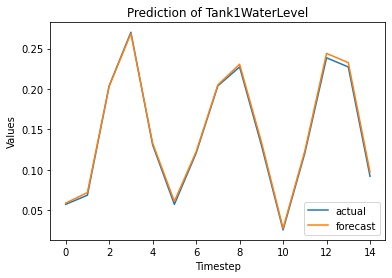

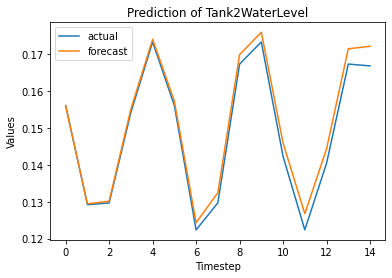

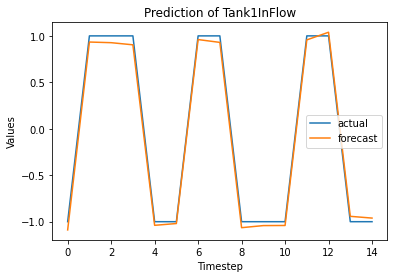

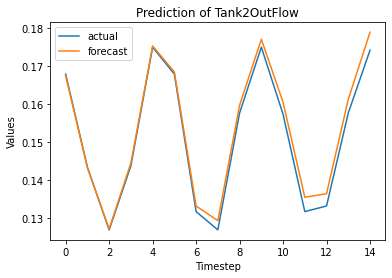

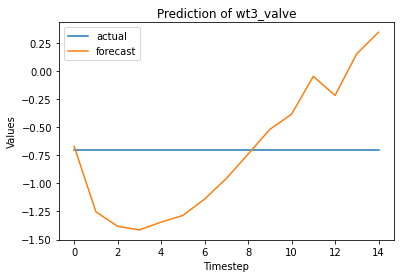

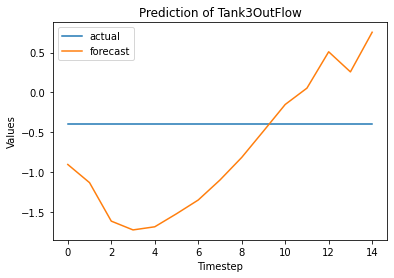

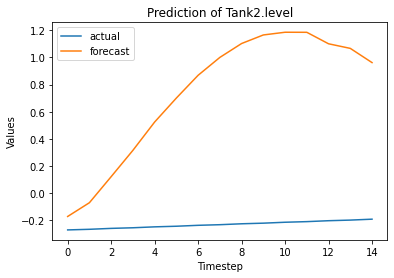

In [24]:
# plot_series(predictions_df, attr)
expected = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected, predictions_df, attr)
# plot_multiple_series(actual, pred, attr)

In [25]:
expected = expected.reset_index(drop=True)
RMSE_golden = []
for feat in attr:
    RMSE_golden.append(root_mse(predictions_df[feat], expected[feat]))
print(RMSE_golden)

[0.0032979715218082167, 0.002839679804154579, 0.058335119350999845, 0.0024205614785654133, 0.5720236340630186, 0.8703162550865208, 1.064904907762949]


#### ValueFlip

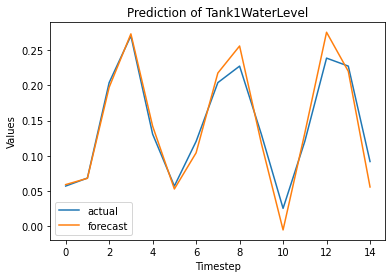

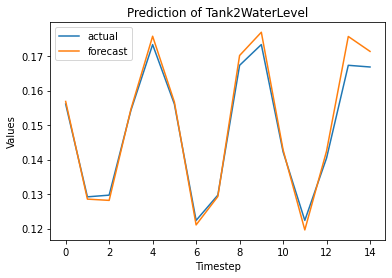

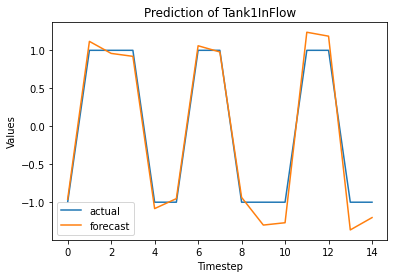

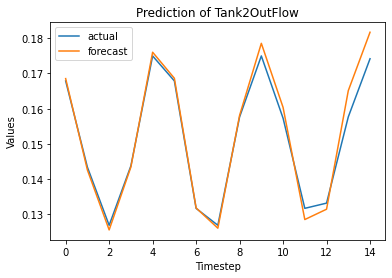

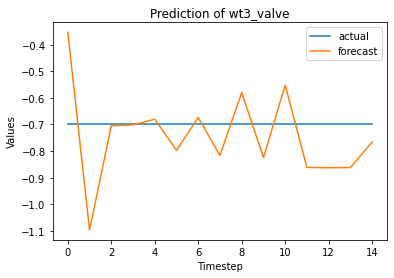

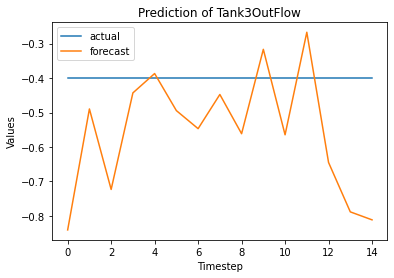

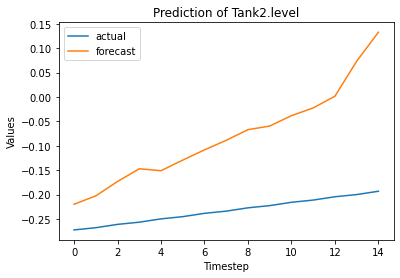

In [26]:
steps = 15
pred_valueFlip = valueFlip_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_valueFlip_df = pd.DataFrame(pred_valueFlip, columns=input1.columns)

# plot_series(predictions_df, attr)
expected_valueFlip = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_valueFlip, pred_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [27]:
expected_valueFlip = expected_valueFlip.reset_index(drop=True)
RMSE_vf = []
for feat in attr:
    RMSE_vf.append(root_mse(pred_valueFlip_df[feat], expected_valueFlip[feat]))
print(RMSE_vf)

[0.018988717707599235, 0.0029974807427399037, 0.17699396345413468, 0.003191718968328713, 0.17061863223986257, 0.23104131605663383, 0.16935887492860277]


### Stuck at zero

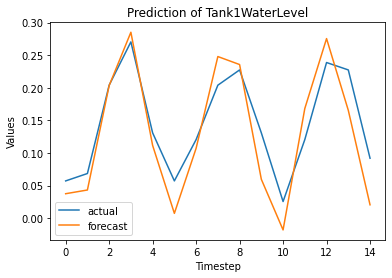

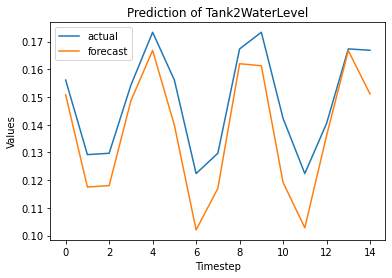

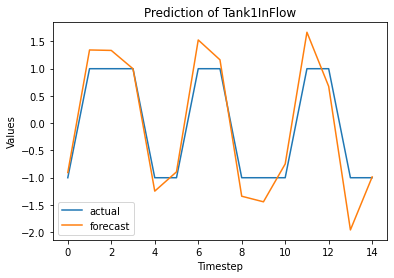

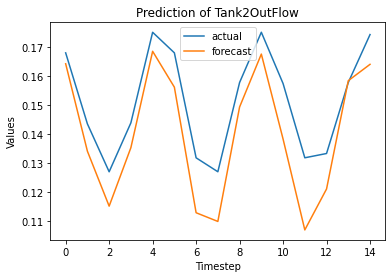

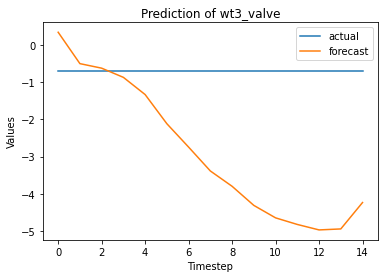

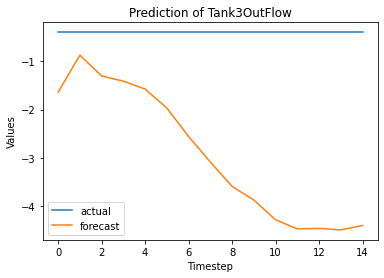

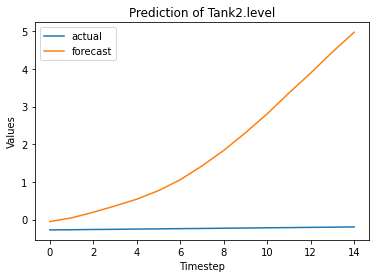

In [28]:
steps = 15
pred_stuckat0 = stuckat0_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_stuckat0_df = pd.DataFrame(pred_stuckat0, columns=input1.columns)

# plot_series(predictions_df, attr)
expected_stuckat0 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_stuckat0, pred_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [29]:
expected_stuckat0 = expected_stuckat0.reset_index(drop=True)
RMSE_s0 = []
for feat in attr:
    RMSE_s0.append(root_mse(pred_stuckat0_df[feat], expected_stuckat0[feat]))

# tested = root_mse(df['Tank1WaterLevel'].iloc[:steps], df_forecast['Tank1WaterLevel'])
# tested
print(RMSE_s0)

[0.04144258142033757, 0.013102253016895356, 0.40497755665044555, 0.01295139796075964, 2.817373577345904, 2.858254375066239, 2.6371824780674253]


### stuckat one

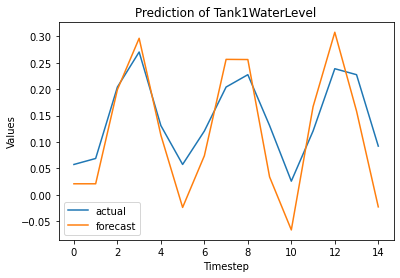

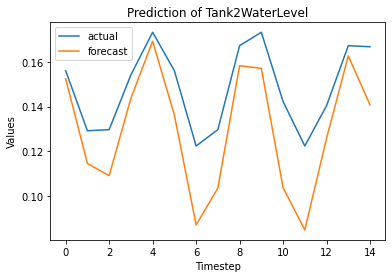

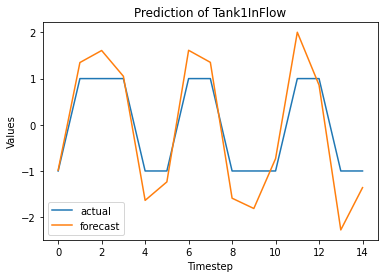

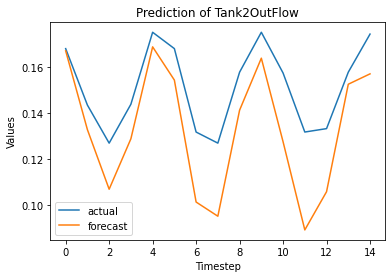

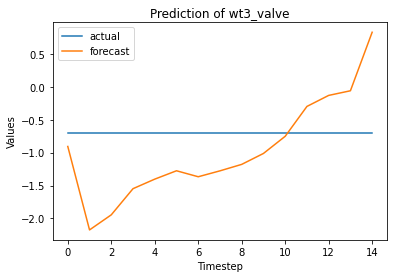

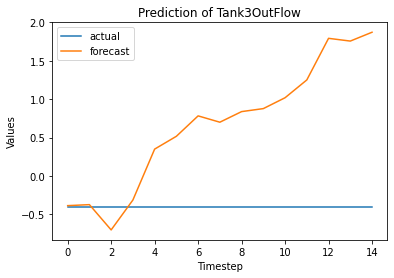

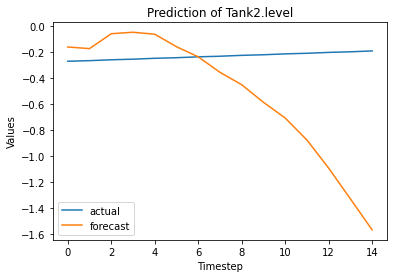

In [30]:
steps = 15
pred_stuckat1 = stuckat1_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_stuckat1_df = pd.DataFrame(pred_stuckat1, columns=input1.columns)
pred_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected_stuckat1 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_stuckat1, pred_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [31]:
# pred_stuckat1_df["Tank1WaterLevel"]
pred_stuckat1_df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0,0.020610,0.152509,-0.984042,0.166908,-0.906372,-0.386192,-0.163031
1,0.020611,0.114539,1.346431,0.132744,-2.173773,-0.373037,-0.175259
2,0.198994,0.109054,1.606781,0.106926,-1.944581,-0.702223,-0.061124
3,0.296324,0.143710,1.049101,0.128793,-1.547407,-0.312990,-0.049802
4,0.112736,0.169308,-1.637855,0.168633,-1.402536,0.349890,-0.064871
5,-0.024177,0.136196,-1.237186,0.154237,-1.275448,0.516744,-0.160757
6,0.073709,0.086972,1.611407,0.101371,-1.366312,0.782547,-0.238390
7,0.256360,0.103495,1.350577,0.095225,-1.276603,0.700172,-0.357203
8,0.256040,0.158336,-1.590757,0.141182,-1.178351,0.838145,-0.452186


In [32]:
expected_stuckat1 = expected_stuckat1.reset_index(drop=True)
RMSE_s1 = []
for feat in attr:
    RMSE_s1.append(root_mse(pred_stuckat1_df[feat], expected_stuckat1[feat]))

print(RMSE_s1)

[0.06322393705833707, 0.022024413818756895, 0.5953618886891873, 0.021672217755832227, 0.8018456420029508, 1.3320747096814007, 0.5756767389739332]


### Predict with the pretrained models
#### Golden model

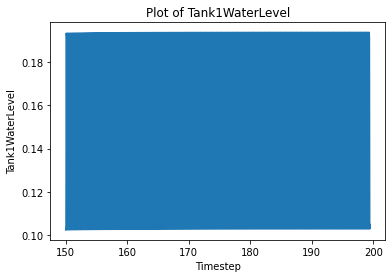

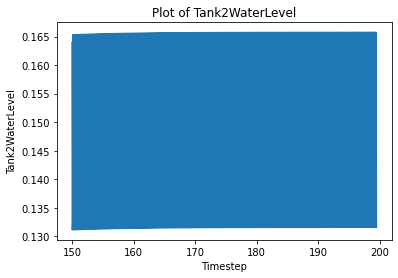

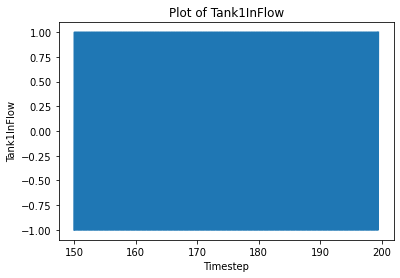

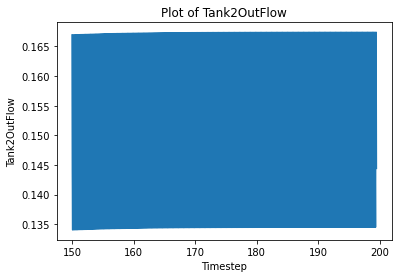

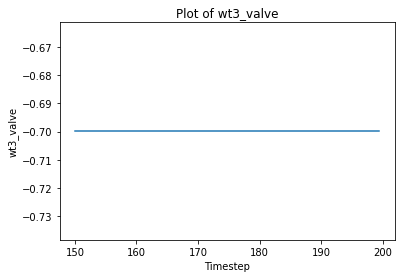

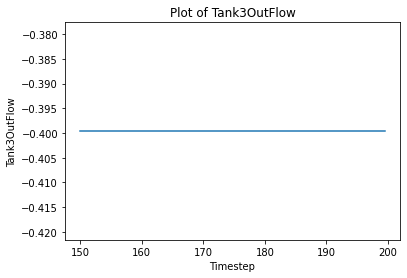

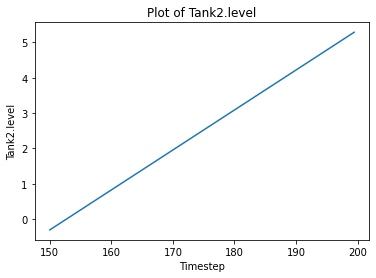

In [33]:
## SPecify the signal range
begin = 3000
finish = 3990
input2 = testData.iloc[begin:finish,:]

## Visualise the input signals
plot_series(input2,attr)

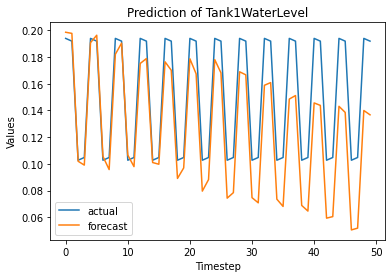

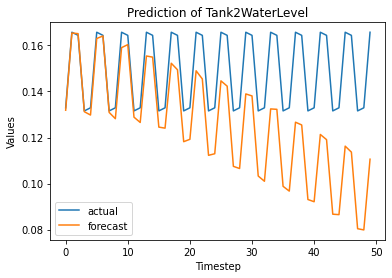

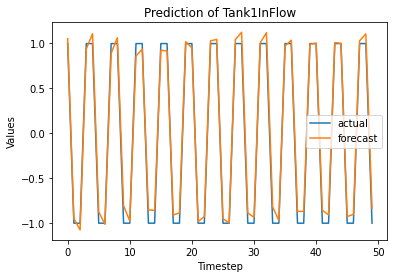

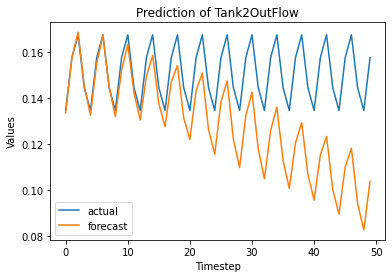

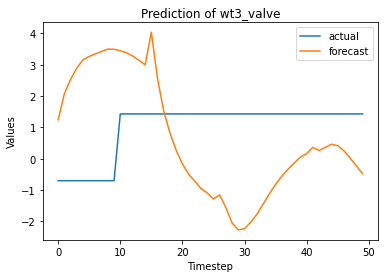

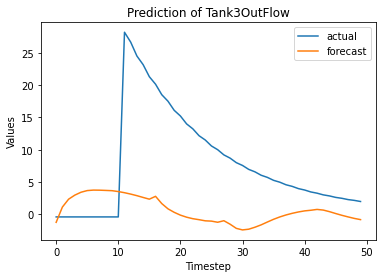

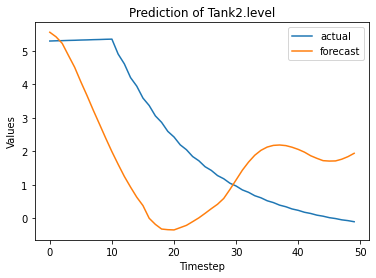

In [34]:
steps = 50
predictions2 = golden_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
predictions2_df = pd.DataFrame(predictions2, columns=input1.columns)

# plot_series(predictions_df, attr)
expected2 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2, predictions2_df, attr)
# plot_multiple_series(actual, pred, attr)

In [35]:
expected2 = expected2.reset_index(drop=True)
RMSE2_golden = []
for feat in attr:
    RMSE2_golden.append(root_mse(predictions2_df[feat], expected2[feat]))
print(RMSE2_golden)

[0.030144872341506913, 0.028473159791328976, 0.09113288693322492, 0.027335517538646256, 2.512226191574946, 10.72599756080526, 2.0657489898914765]


#### ValueFlip

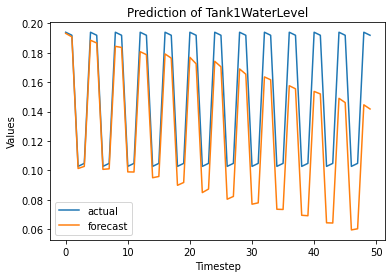

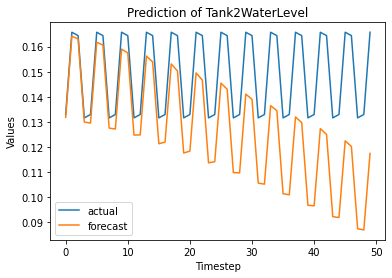

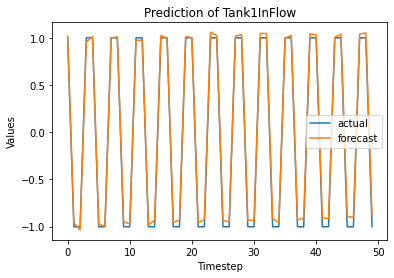

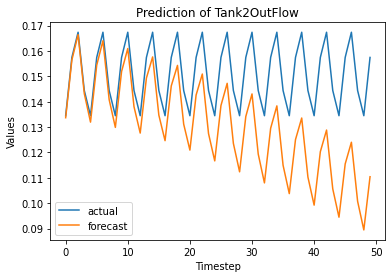

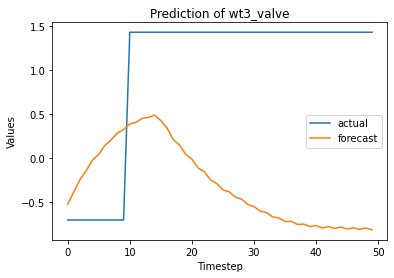

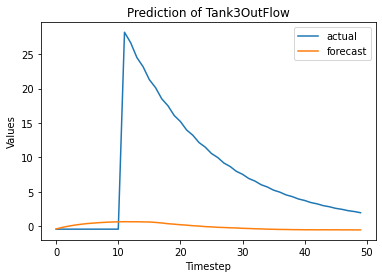

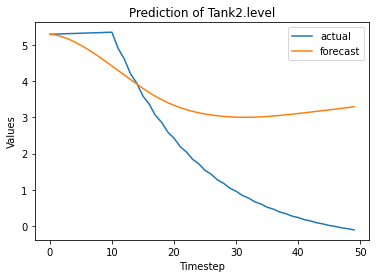

In [36]:
steps = 50
pred2_valueFlip = valueFlip_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_valueFlip_df = pd.DataFrame(pred2_valueFlip, columns=input2.columns)

# plot_series(predictions_df, attr)
expected2_valueFlip = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_valueFlip, pred2_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [37]:
expected2_valueFlip = expected2_valueFlip.reset_index(drop=True)
RMSE2_vf = []
for feat in attr:
    RMSE2_vf.append(root_mse(pred2_valueFlip_df[feat], expected2_valueFlip[feat]))
print(RMSE2_vf)

[0.026600321377196697, 0.025492943140269193, 0.05354763276504156, 0.02460911044158302, 1.680581119313033, 10.938500933936371, 1.936433864401765]


### Stuck at zero

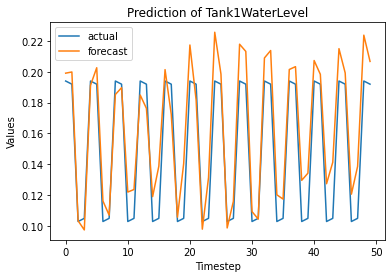

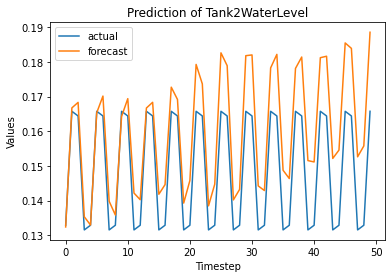

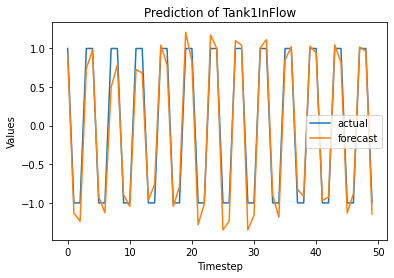

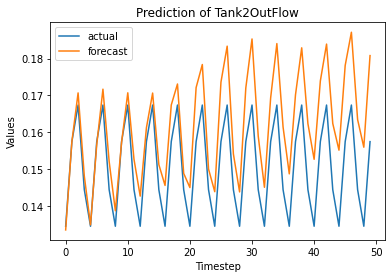

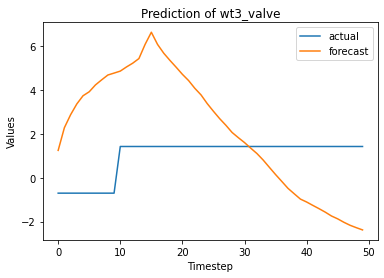

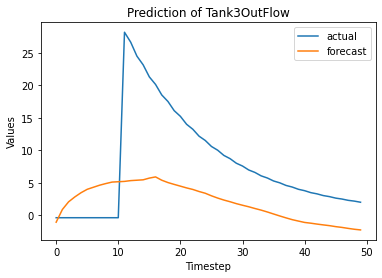

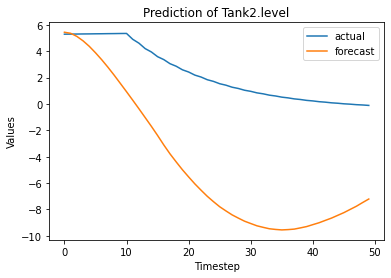

In [38]:
steps = 50
pred2_stuckat0 = stuckat0_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_stuckat0_df = pd.DataFrame(pred2_stuckat0, columns=input2.columns)

# plot_series(predictions_df, attr)
expected2_stuckat0 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_stuckat0, pred2_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [39]:
expected2_stuckat0 = expected2_stuckat0.reset_index(drop=True)
RMSE2_s0 = []
for feat in attr:
    RMSE2_s0.append(root_mse(pred2_stuckat0_df[feat], expected2_stuckat0[feat]))

print(RMSE2_s0)

[0.01813896283538127, 0.013153401723425695, 0.1757655854471897, 0.012788137135871172, 3.262700479852698, 8.847931390922925, 7.645836218075348]


### stuckat one

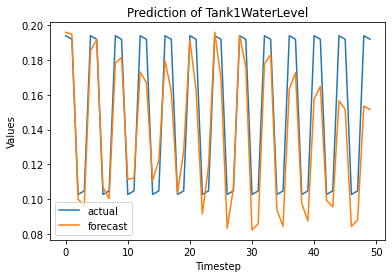

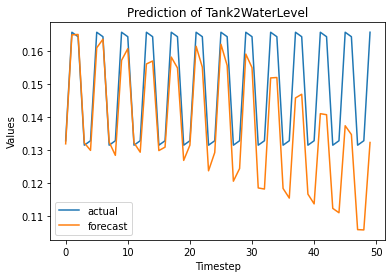

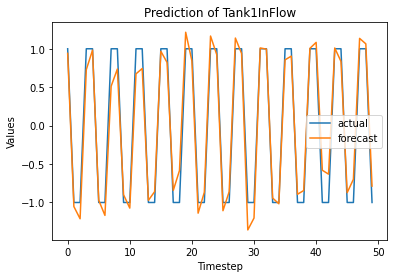

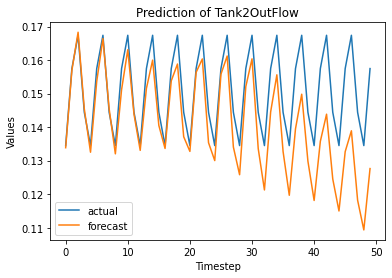

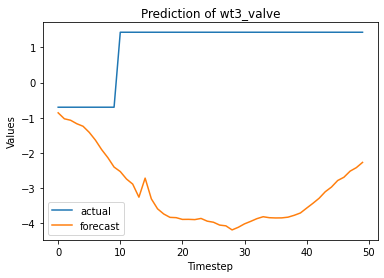

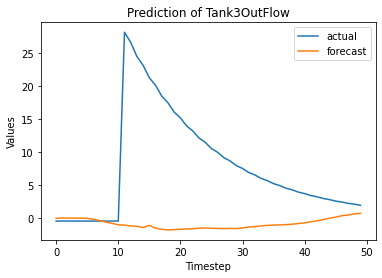

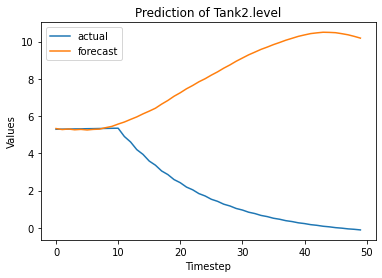

In [40]:
steps = 50
pred2_stuckat1 = stuckat1_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_stuckat1_df = pd.DataFrame(pred2_stuckat1, columns=input2.columns)
pred2_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected2_stuckat1 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_stuckat1, pred2_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [41]:
expected2_stuckat1 = expected2_stuckat1.reset_index(drop=True)
RMSE2_s1 = []
for feat in attr:
    RMSE2_s1.append(root_mse(pred2_stuckat1_df[feat], expected2_stuckat1[feat]))

print(RMSE2_s1)

[0.019153801664256783, 0.013939928552155822, 0.19252404367580858, 0.012885569683988225, 4.447816997060087, 11.981455425817542, 6.946702273786576]


### Predict with the pretrained models
#### Golden model

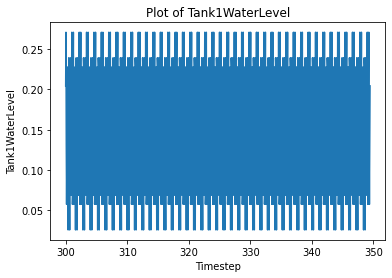

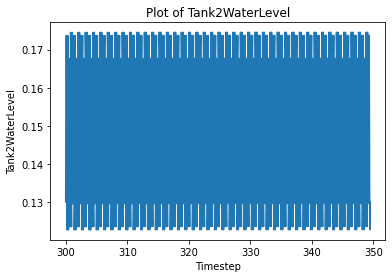

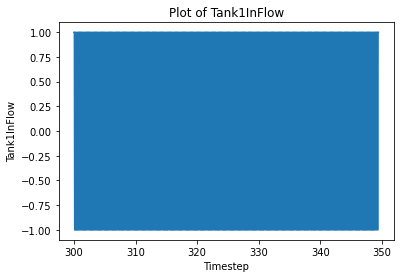

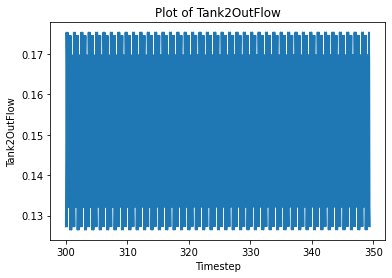

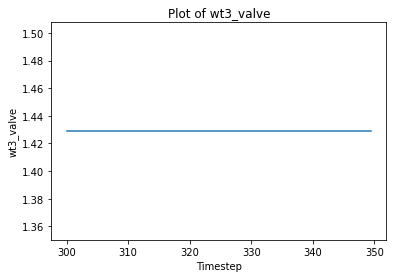

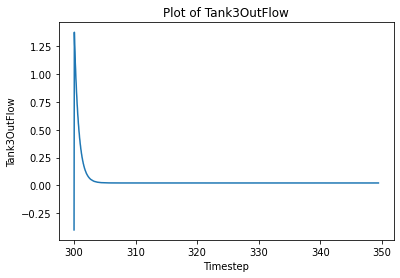

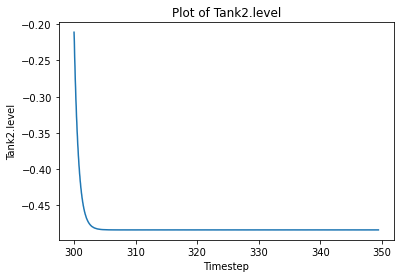

In [42]:
## SPecify the signal range
begin3 = 6000
finish3 = 6990
input3 = testData.iloc[begin3:finish3,:]

## Visualise the input signals
plot_series(input3,attr)

In [43]:
steps = 50
predictions3 = golden_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
predictions3_df = pd.DataFrame(predictions3, columns=input3.columns)

print(predictions3_df)

    Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
0          0.216019         0.166113    -0.975789      0.157514   0.421254   
1          0.116162         0.169464    -0.910101      0.172303   0.876512   
2          0.027485         0.137562    -0.847375      0.152430   1.372945   
3          0.130865         0.119671     1.052213      0.127695   1.589426   
4          0.229816         0.138352     0.840424      0.131193   1.654957   
5          0.201399         0.162427    -1.150240      0.154791   1.773216   
6          0.083575         0.157737    -0.918624      0.165948   1.761639   
7          0.040543         0.133733    -0.727663      0.147112   1.652854   
8          0.164744         0.118801     0.897461      0.120669   1.470860   
9          0.217605         0.137756     0.737052      0.131432   1.442346   
10         0.160336         0.165206    -0.943222      0.161719   1.412767   
11         0.097388         0.155471    -0.742675      0.162495 

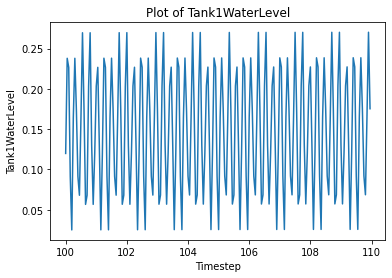

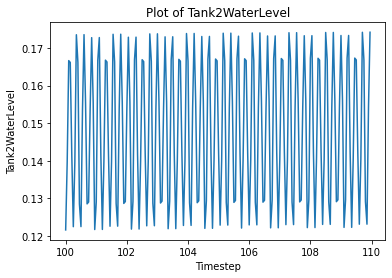

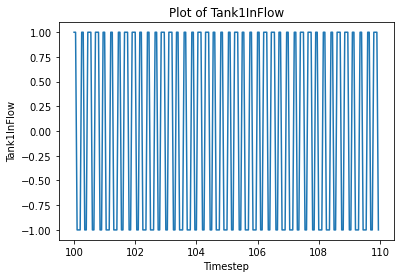

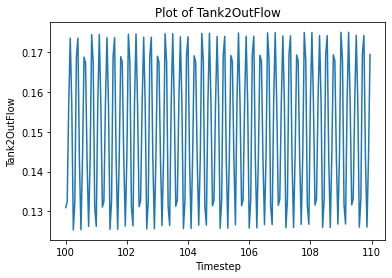

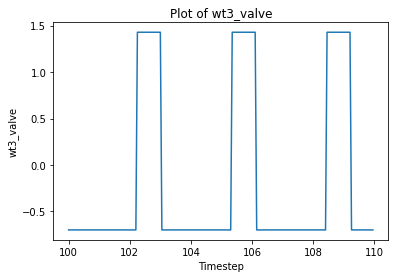

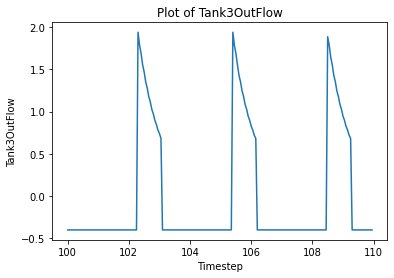

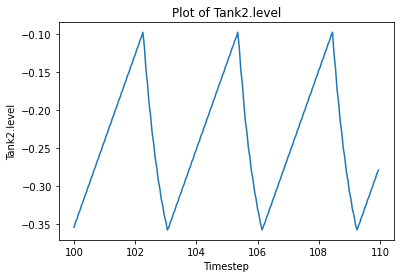

In [128]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
# mydata = read_csv('test_fault.csv', header=0, index_col=0)
# mydata = read_csv('test_series.csv', header=0, index_col=0)
attr = list(pd.read_csv("test_series.csv").columns.values)[1:]
for i in range(len(attr)):
    title = "Plot of "+str(attr[i])
#     actual = mydata.iloc[:400,i]
#     actual = mydata.iloc[:4000,i]
    actual = input1.iloc[:,i]
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
#     plt.plot(actual, label="original")
    plt.plot(actual)
#     plt.legend()
    plt.show()